Train model on given data

## Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from kneed import KneeLocator
import random
import os
import json

In [4]:
current_dir = os.getcwd()

In [9]:
current_dir

'd:\\E\\Study\\Projects\\basicml\\scripts\\training'

In [43]:
input_file=os.path.abspath(current_dir+"../../../data/training/data.csv")
training_logs_file=os.path.abspath(current_dir+"../../../data/training/training_logs.json")
training_data_path=os.path.abspath(current_dir+"../../../data/training/")
plots_path=os.path.abspath(current_dir+"../../../plots/")

## Generate Data and Save

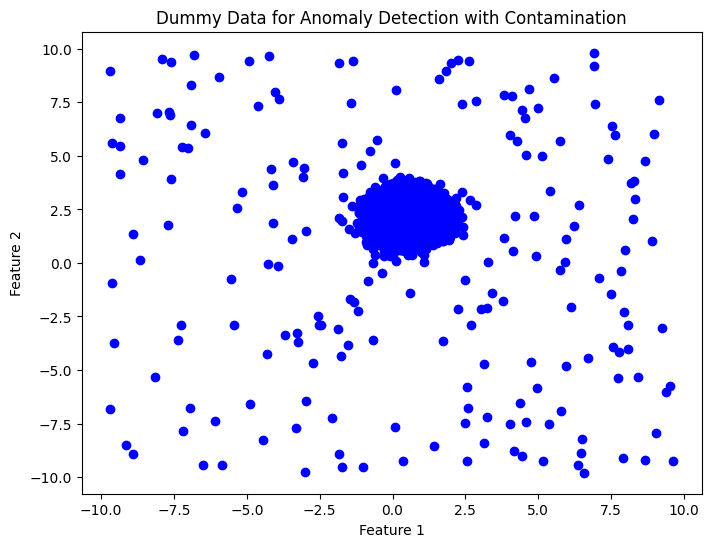

In [2]:
def generate_dummy_data(n_samples, contamination):
    # Generate normal data
    np.random.seed(0)
    normal_data, _ = make_blobs(n_samples=int(n_samples * (1 - contamination)), centers=1, cluster_std=0.5, center_box=(-5, 5))

    # Generate anomalies (contamination)
    anomaly_data= np.random.uniform(low=-10, high=10, size=(int(n_samples * contamination), 2))

    # Combine normal and anomaly data
    data = np.vstack([normal_data, anomaly_data])

    # Shuffle the data
    np.random.shuffle(data)
    
    return data

# Example usage
data = generate_dummy_data(n_samples=20000, contamination=0.01)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='b')
plt.title('Dummy Data for Anomaly Detection with Contamination')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [4]:
df = pd.DataFrame(data, columns=['column1','column2'])
df.to_csv(input_file, index=False)

## Read data

In [13]:
input_file

'd:\\E\\Study\\Projects\\basicml\\data\\training\\data.csv'

In [14]:
df = pd.read_csv(input_file)
df.head()

,column1,column2
0,0.296106,2.078786
1,0.478983,1.980522
2,-0.054076,1.874311
3,0.467953,2.151608
4,0.474437,2.755243


In [15]:
df.shape

(20000, 2)

## Feature Engineering

## Hyperparameter tuning

Preparation

e^-(X^2) is a function which maps 

0 to 1

-inf to 0

+inf to 0

In [16]:
def calculate_avg_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    avg_anomaly_score = np.mean(anomaly_scores)
    return avg_anomaly_score

def calculate_max_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    max_anomaly_score = max(anomaly_scores)
    return max_anomaly_score

def calculate_adv1_avg_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    avg_anomaly_score = np.e**(-(np.mean(anomaly_scores)-0.1)**2)
    return avg_anomaly_score

actual

In [71]:
iterations = 5
main_start_point=0.0001
main_end_point=0.2
main_intervals=4
step=(main_end_point-main_start_point)/main_intervals
points_in_each_interval=5
small_step=step/points_in_each_interval
knee_points=[]
training_logs = {}

for iteration in range(iterations):
    print("iteration: ",iteration)
    range_=[]

    start_point=main_start_point
    for _ in range(main_intervals):
        for _ in range(points_in_each_interval):
            #range_.append(random.uniform(start_point,start_point+step))
            range_.append(start_point+small_step)
        start_point=start_point+step

    range_.sort()
    neg_range_ = [-i for i in range_]
 
    avg_anomaly_scores=[]
    #max_anomaly_scores=[]
    for parameter in range_:
        model = IsolationForest(contamination=parameter,max_features=df.shape[1],max_samples=0.8)
        model.fit(df.values)
        outliers = model.predict(df.values)
        anomaly_indices = np.where(outliers == -1)[0]
        df_anomaly = df.iloc[anomaly_indices]
        avg_anomaly_scores.append(calculate_avg_anomaly_score(model, df_anomaly))
        #max_anomaly_scores.append(calculate_max_anomaly_score(model, df_anomaly))

    knee_locator = KneeLocator(neg_range_, avg_anomaly_scores, curve='concave', direction='increasing')
    knee_point = knee_locator.knee
    knee_point = None if knee_point==None else -knee_point
    knee_points.append(knee_point)

    training_logs.update({"{}".format(iteration):
                    {
                    'range_':range_,
                    'neg_range_': neg_range_,
                    'avg_anomaly_scores': avg_anomaly_scores,
                    'knee_point':knee_point                    
                    }})

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4


## Dump training logs

In [72]:
# all in one
with open(training_logs_file, 'w') as f:
    json.dump(training_logs, f)

In [73]:
# Each iteration separately
for iteration in range(iterations):
    range_ = training_logs.get("{}".format(iteration)).get("range_")
    neg_range = [-i for i in range_]
    avg_anomaly_scores = training_logs.get("{}".format(iteration)).get("avg_anomaly_scores")
    pd.DataFrame({
        'parameter':range_,
        'avg_anomaly_scores':avg_anomaly_scores        
        }).to_csv(training_data_path+"/iteration-{}.csv".format(iteration),index=False)


In [74]:
training_data_path

'd:\\E\\Study\\Projects\\basicml\\data\\training'

## Read training logs

In [75]:
with open(training_logs_file, 'r') as f:
    training_logs = json.load(f)

## Visualize training logs

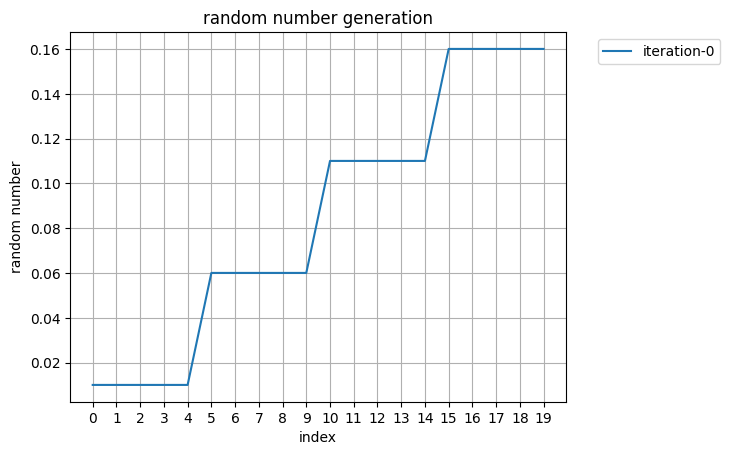

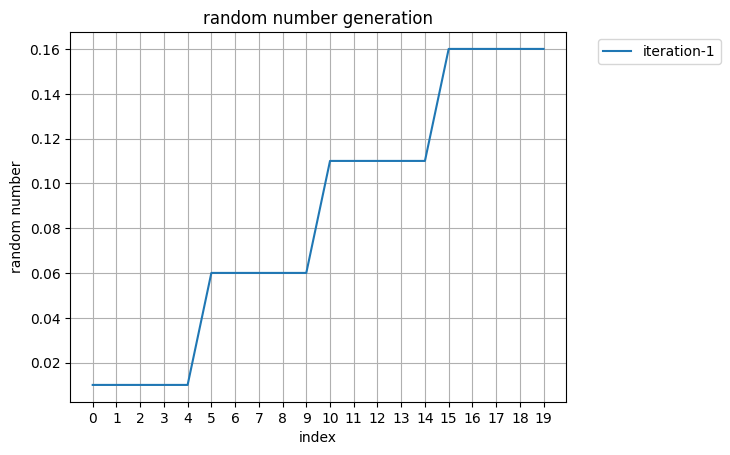

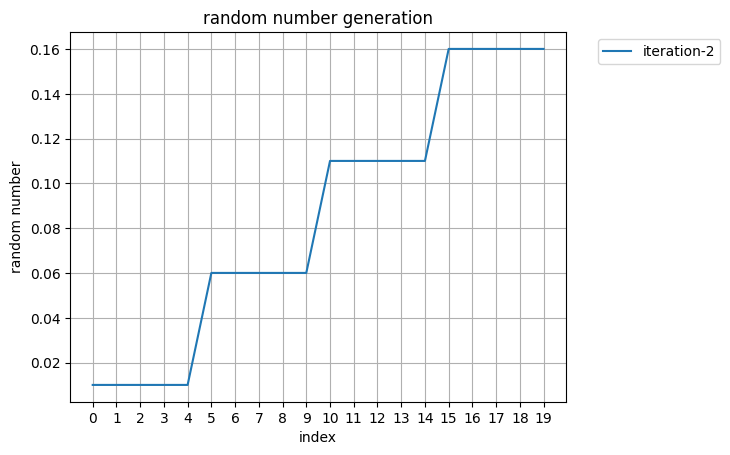

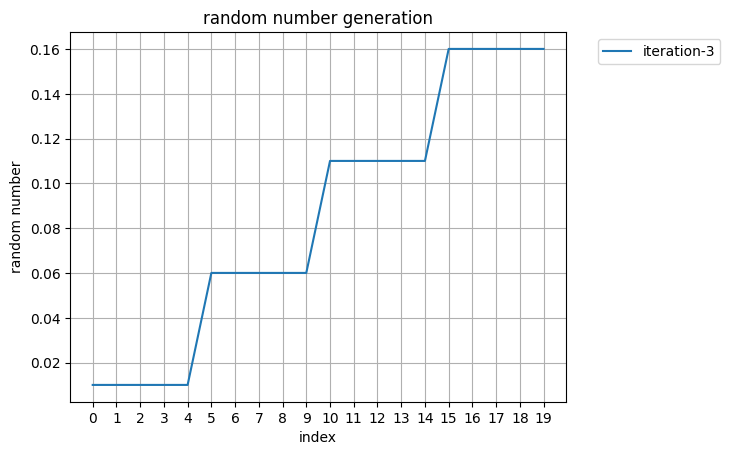

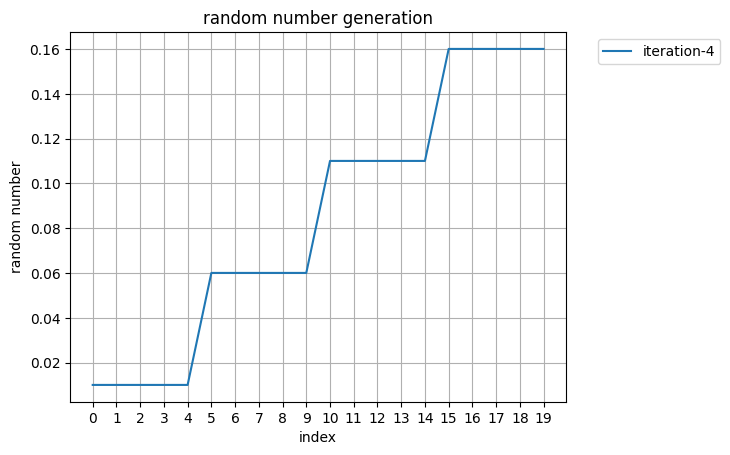

In [76]:
for i in range(iterations):
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    avg_anomaly_scores = training_logs.get("{}".format(i)).get("avg_anomaly_scores")
    plt.plot(range(len(range_)),range_,label="iteration-{}".format(i))
    plt.xlabel("index")
    plt.ylabel("random number")
    plt.title("random number generation")
    plt.xticks(range(len(range_)))
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.savefig(plots_path+"/training-random_number_generation-iteration-{}.png".format(i))
    plt.show()
    plt.close()


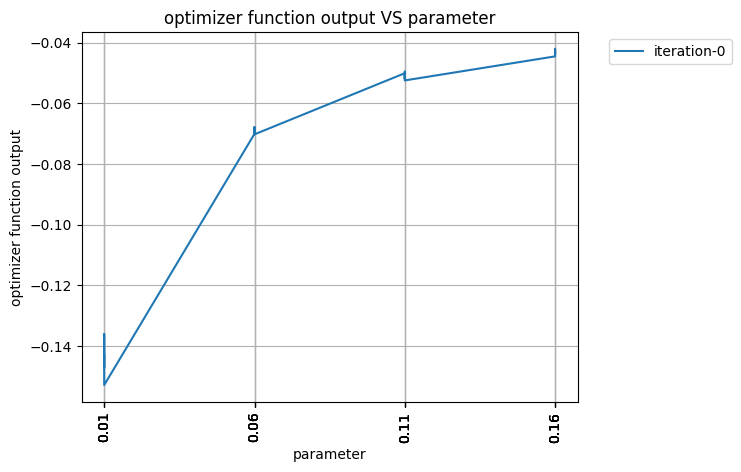

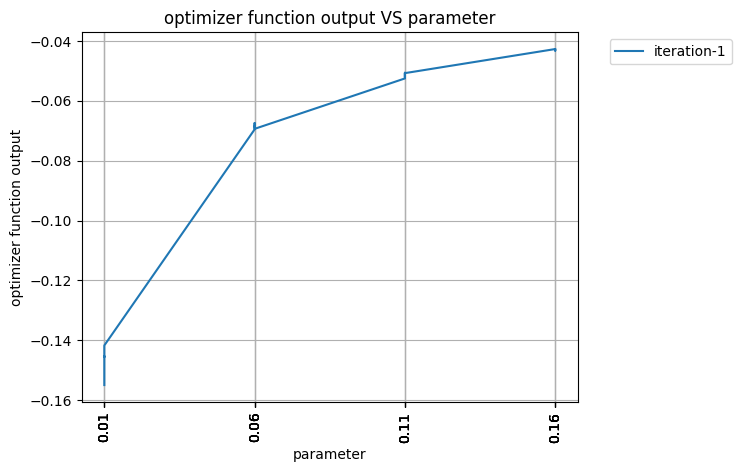

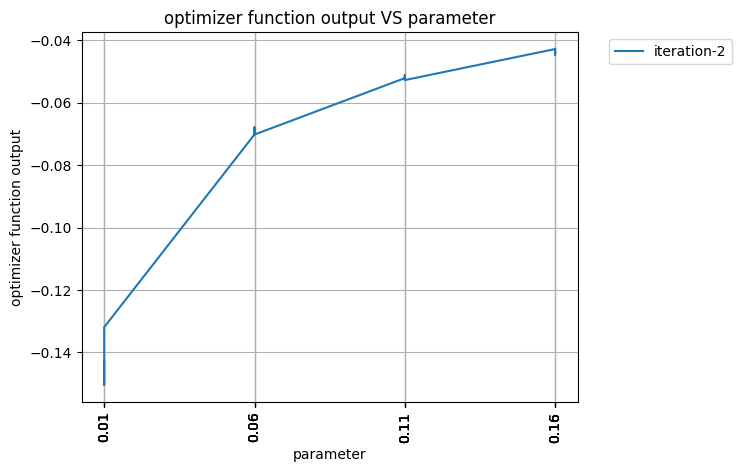

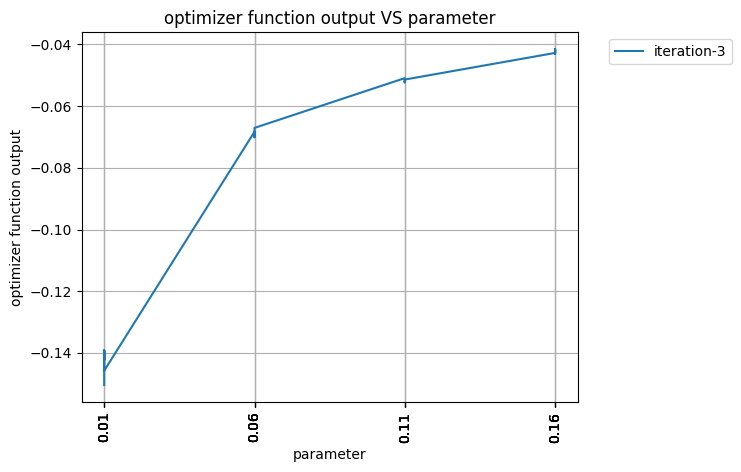

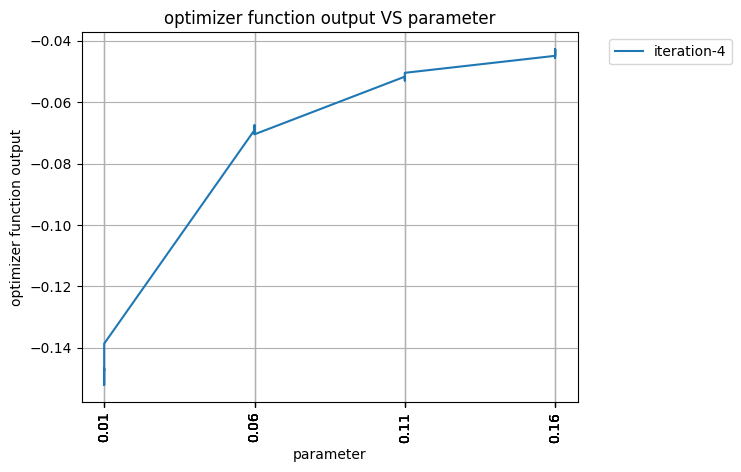

In [77]:
for i in range(iterations):
    range_ = training_logs.get("{}".format(i)).get("range_")
    avg_anomaly_scores = training_logs.get("{}".format(i)).get("avg_anomaly_scores")
    plt.plot(range_,avg_anomaly_scores,label="iteration-{}".format(i))
    plt.xlabel("parameter")
    plt.ylabel("optimizer function output")
    plt.title("optimizer function output VS parameter")
    plt.xticks(range_, rotation='vertical')
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.savefig(plots_path+"/training-parameter_and_output-iteration-{}.png".format(i))
    plt.show()
    plt.close()

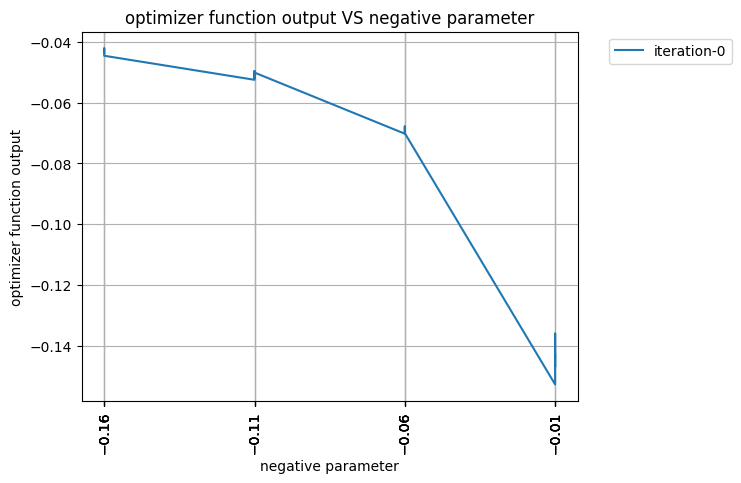

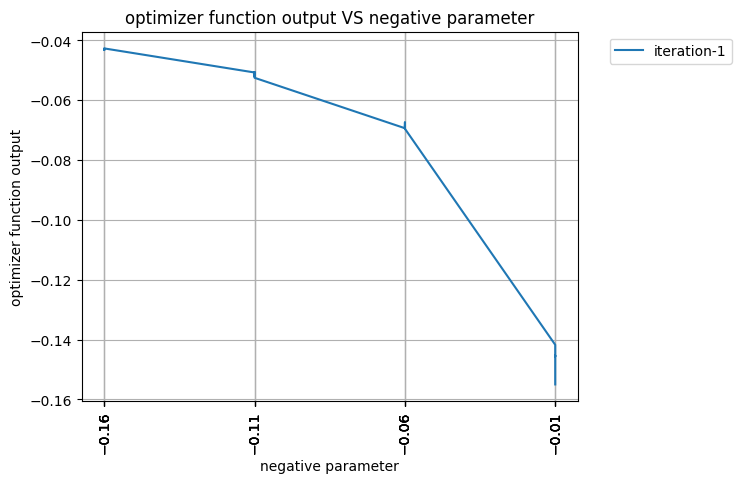

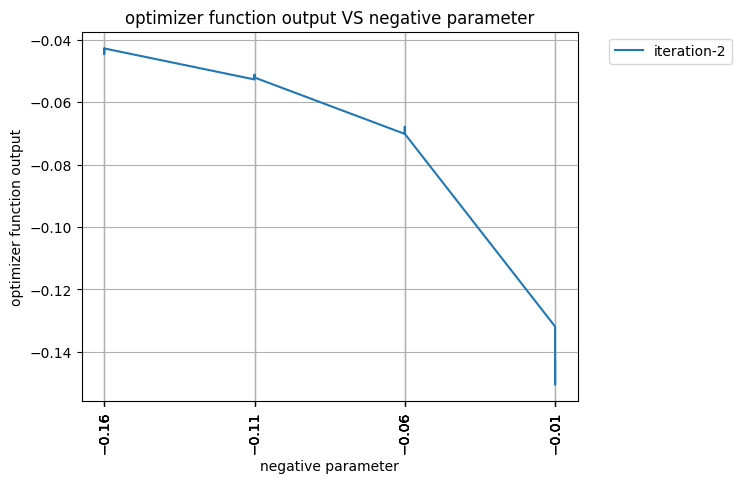

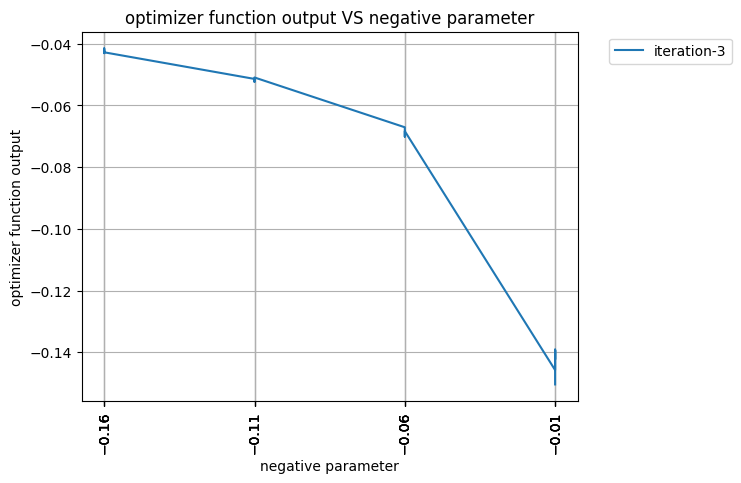

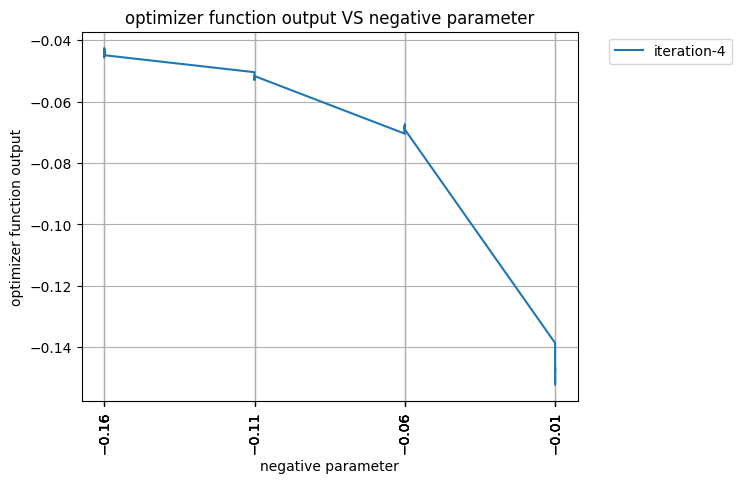

In [78]:
for i in range(iterations):
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    avg_anomaly_scores = training_logs.get("{}".format(i)).get("avg_anomaly_scores")
    plt.plot(neg_range,avg_anomaly_scores,label="iteration-{}".format(i))
    plt.xlabel("negative parameter")
    plt.ylabel("optimizer function output")
    plt.title("optimizer function output VS negative parameter")
    plt.xticks(neg_range,rotation='vertical')
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.savefig(plots_path+"/negative_training-parameter_and_output-iteration-{}.png".format(i))
    plt.show()
    plt.close()

## Get the best parameter

In [79]:
print(knee_points)
while None in knee_points:
    knee_points.remove(None)
print(knee_points)
final_optimized_parameter = np.mean(knee_points)
print(final_optimized_parameter)

[0.010095, 0.010095, 0.010095, 0.010095, 0.010095]
[0.010095, 0.010095, 0.010095, 0.010095, 0.010095]
0.010095


## Final model

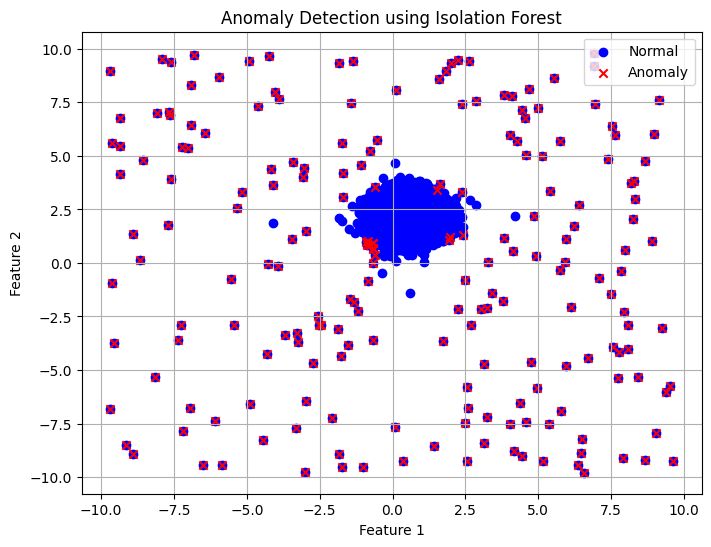

In [80]:
# Create and fit the Isolation Forest model
model = IsolationForest(contamination=final_optimized_parameter,max_features=df.shape[1])
model.fit(df.values)

# Predict outliers/anomalies
outliers = model.predict(df.values)

# Anomalies will be labeled as -1, normal points as 1
anomaly_indices = np.where(outliers == -1)[0]

# Visualize the data with anomalies highlighted
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Save model

In [34]:
import pickle

with open('./../../resources/model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Inference

In [35]:
#inference
given_point = [4,-4]
given_point = [np.array(given_point)]
model.predict(given_point)[0]

-1